In [1]:
import os, time, copy, random
import numpy as np
from pprint import pprint

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam, SGD

In [2]:
DEVICE = "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.set_num_threads(max(1, (os.cpu_count() or 4)-1))

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
root = "./data"
full_train = datasets.MNIST(root, train=True, download=True, transform=transform)
test_set   = datasets.MNIST(root, train=False, download=True, transform=transform)

val_len = 6000
train_len = len(full_train) - val_len
train_set, val_set = random_split(full_train, [train_len, val_len],
                                  generator=torch.Generator().manual_seed(SEED))

BATCH = 128
def make_loader(ds, shuffle=False):
    return DataLoader(ds, batch_size=BATCH, shuffle=shuffle, num_workers=max(2,(os.cpu_count() or 4)//2))

train_loader = make_loader(train_set, True)
val_loader   = make_loader(val_set, False)
test_loader  = make_loader(test_set, False)


In [4]:
class CNNBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                                  # 28->14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                                  # 14->7
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x): return self.h(self.f(x))

class CNN_BN(CNNBase):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
        )

class CNN_Drop(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(p),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(p),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(), nn.Dropout(p),
            nn.Linear(128, 10)
        )
    def forward(self, x): return self.h(self.f(x))

class CNN_Stride(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),  # 28->14
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(), # 14->7
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x): return self.h(self.f(x))

class CNN_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.h(self.f(x))

In [5]:
def train_one(model, epochs=12, lr=1e-3, wd=1e-4, optim_name="adam", patience=3, verbose=True):
    model.to(DEVICE)
    crit = nn.CrossEntropyLoss()
    if optim_name == "sgd":
        opt = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov=True)
    else:
        opt = Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_state, best_val = None, -1.0
    no_improve = 0

    for ep in range(1, epochs+1):
        # train
        model.train()
        tl, ta, n = 0.0, 0.0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            tl += loss.item() * x.size(0)
            ta += (logits.argmax(1) == y).float().sum().item()
            n  += x.size(0)
        tl /= n; ta /= n

        # val
        model.eval()
        vl, va, m = 0.0, 0.0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                loss = crit(logits, y)
                vl += loss.item() * x.size(0)
                va += (logits.argmax(1) == y).float().sum().item()
                m  += x.size(0)
        vl /= m; va /= m

        if verbose:
            print(f"Epoch {ep:02d}/{epochs} | train {tl:.4f}/{ta:.4f} | val {vl:.4f}/{va:.4f}")

        # early stop
        if va > best_val:
            best_val = va
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose:
                    print(f"  -> early stop (best val acc={best_val:.4f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val

@torch.no_grad()
def eval_test(model):
    model.eval()
    crit = nn.CrossEntropyLoss()
    loss, acc, n = 0.0, 0.0, 0
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss += crit(logits, y).item() * x.size(0)
        acc  += (logits.argmax(1) == y).float().sum().item()
        n += x.size(0)
    return loss/n, acc/n

In [7]:
# baseline 하나만 실행
name = "baseline"
model = CNNBase()  # baseline 모델 생성
model, best_val = train_one(
    model,
    epochs=12,
    lr=1e-3,
    optim_name="adam",
    patience=3,
    verbose=True
)

tl, ta = eval_test(model)
print("\n=== Summary ===")
print({
    "name": name,
    "val_acc": round(best_val, 4),
    "test_acc": round(ta, 4),
    "test_loss": round(tl, 4),
    "optim": "adam",
    "lr": 1e-3
})

Epoch 01/12 | train 0.1807/0.9454 | val 0.0701/0.9788
Epoch 02/12 | train 0.0513/0.9839 | val 0.0544/0.9838
Epoch 03/12 | train 0.0349/0.9883 | val 0.0439/0.9875
Epoch 04/12 | train 0.0262/0.9920 | val 0.0456/0.9870
Epoch 05/12 | train 0.0202/0.9936 | val 0.0434/0.9875
Epoch 06/12 | train 0.0176/0.9945 | val 0.0444/0.9865
  -> early stop (best val acc=0.9875)

=== Summary ===
{'name': 'baseline', 'val_acc': 0.9875, 'test_acc': 0.9893, 'test_loss': 0.0329, 'optim': 'adam', 'lr': 0.001}


In [8]:
experiments = [
    ("baseline",       CNNBase,   {"epochs":12, "optim":"adam", "lr":1e-3}),
    ("batchnorm",      CNN_BN,    {"epochs":12, "optim":"adam", "lr":1e-3}),
    ("dropout",        lambda: CNN_Drop(p=0.3), {"epochs":12, "optim":"adam", "lr":1e-3}),
    ("stride_padding", CNN_Stride,{"epochs":12, "optim":"adam", "lr":1e-3}),
    ("deep",           CNN_Deep,  {"epochs":12, "optim":"sgd",  "lr":0.05}),
]

results = []
t0_all = time.time()
for name, fn, cfg in experiments:
    print(f"\n=== {name} ===")
    model = fn() if callable(fn) else fn
    model, best_val = train_one(model,
                                epochs=cfg.get("epochs",12),
                                lr=cfg.get("lr",1e-3),
                                optim_name=cfg.get("optim","adam"),
                                patience=3, verbose=True)
    tl, ta = eval_test(model)
    results.append({"name": name, "val_acc": round(best_val,4),
                    "test_acc": round(ta,4), "test_loss": round(tl,4),
                    "optim": cfg.get("optim","adam"), "lr": cfg.get("lr",1e-3)})
print("\n=== Summary ===")
pprint(results)
print(f"Total time: {int(time.time()-t0_all)}s")


=== baseline ===
Epoch 01/12 | train 0.1748/0.9475 | val 0.0611/0.9820
Epoch 02/12 | train 0.0484/0.9854 | val 0.0509/0.9878
Epoch 03/12 | train 0.0346/0.9889 | val 0.0448/0.9858
Epoch 04/12 | train 0.0267/0.9914 | val 0.0392/0.9880
Epoch 05/12 | train 0.0199/0.9937 | val 0.0481/0.9863
Epoch 06/12 | train 0.0187/0.9937 | val 0.0461/0.9875
Epoch 07/12 | train 0.0147/0.9952 | val 0.0393/0.9880
  -> early stop (best val acc=0.9880)

=== batchnorm ===
Epoch 01/12 | train 0.1459/0.9555 | val 0.0846/0.9745
Epoch 02/12 | train 0.0496/0.9842 | val 0.0927/0.9725
Epoch 03/12 | train 0.0357/0.9885 | val 0.0474/0.9863
Epoch 04/12 | train 0.0292/0.9909 | val 0.0469/0.9853
Epoch 05/12 | train 0.0244/0.9922 | val 0.0418/0.9880
Epoch 06/12 | train 0.0167/0.9947 | val 0.0389/0.9893
Epoch 07/12 | train 0.0172/0.9942 | val 0.0412/0.9887
Epoch 08/12 | train 0.0153/0.9948 | val 0.0284/0.9902
Epoch 09/12 | train 0.0148/0.9952 | val 0.0450/0.9887
Epoch 10/12 | train 0.0123/0.9958 | val 0.0304/0.9912
Epoch 1


[Results Table]
             name  val_acc  test_acc  test_loss optim     lr
2         dropout   0.9913    0.9933     0.0198  adam  0.001
1       batchnorm   0.9918    0.9906     0.0308  adam  0.001
0        baseline   0.9880    0.9901     0.0304  adam  0.001
4            deep   0.9897    0.9901     0.0330   sgd  0.050
3  stride_padding   0.9867    0.9859     0.0475  adam  0.001


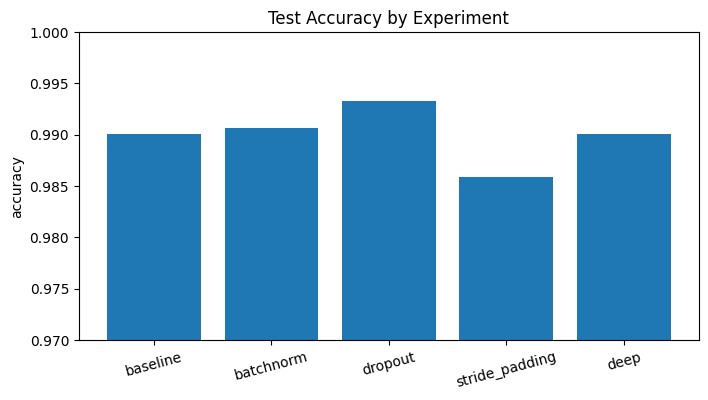

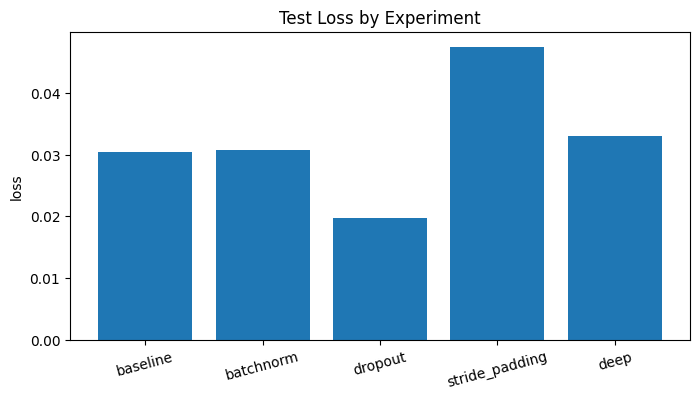

In [9]:
# === Test 결과 비교: 막대그래프 & 표 ===
import matplotlib.pyplot as plt
import pandas as pd

# results -> DataFrame
df = pd.DataFrame(results)
print("\n[Results Table]")
print(df.sort_values("test_acc", ascending=False))

# Test Accuracy
plt.figure(figsize=(8,4))
plt.bar(df["name"], df["test_acc"])
plt.title("Test Accuracy by Experiment"); plt.ylabel("accuracy")
plt.ylim(0.97, 1.0); plt.xticks(rotation=15)
plt.show()

# Test Loss
plt.figure(figsize=(8,4))
plt.bar(df["name"], df["test_loss"])
plt.title("Test Loss by Experiment"); plt.ylabel("loss")
plt.xticks(rotation=15)
plt.show()


In [ ]:
# 결과해석
# Dropout(0.3): test_acc 0.9933 (최고), test_loss도 가장 낮음 → 과적합이 살짝 있었고 Dropout이 일반화를 가장 잘 도와줌.

# BatchNorm: baseline 대비 +0.005p 내외 상승(0.9906) → 수렴 안정 + 소폭의 일반화 이득.

# Baseline: 0.9901 → MNIST 기준 무난.

# Deep(더 깊게): 0.9901로 baseline과 거의 동일 → 깊이만 늘린 것이 추가 이득을 보장하진 않음(최적화/정규화 더 필요).

# Stride 다운샘플: 0.9859로 가장 낮음, loss도 가장 큼 → MaxPool을 줄이고 stride=2로만 다운샘플하면 정보 손실/최적화 불리